<a href="https://colab.research.google.com/github/hamidbekam9193-ui/Lectures/blob/main/2_KG_Construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### 📓 Practical 2: Deep Dive - Building a Knowledge Graph for a Single Movie

**Objective:**
In this practical, we'll build a **deep** knowledge graph, modeling the rich internal world of a **single movie**. We will use its plot summary to extract characters, key items, and the interactions between them. This is a common task in "domain modeling," where the goal is to create a detailed, specialized KG about one specific topic.

  * Use `spaCy` to process a detailed movie plot summary.
  * Identify **Characters**, **Locations**, and **Items** as node types.
  * Use **sentence analysis** to infer relationships like `[:INTERACTS_WITH]`.
  * Build and visualize a new, highly-connected graph for our chosen movie.
  * Compare our programmatic approach to a zero-shot KG generated by an LLM.

-----

In [ ]:
# ==============
# SETUP
# ==============
# Install necessary libraries
!pip install spacy networkx pandas matplotlib --quiet

# Download the small English model for spaCy
!python -m spacy download en_core_web_sm --quiet

# Download the movie plots dataset
#donload data here: https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots

-----

In [ ]:
import spacy
from spacy import displacy
from spacy.matcher import Matcher
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

# Load the spaCy model. Larger models (md, lg) would yield better entity recognition.
nlp = spacy.load("en_core_web_sm")

-----

### Part 1: Named Entity Recognition (NER) Primer

NER is the core NLP task for finding and categorizing named entities in text. `spaCy` automatically assigns labels like `PERSON`, `ORG` (organization), etc. This is our primary tool for discovering potential nodes for our graph.

-----

In [ ]:
sentence = "The movie Titanic, directed by James Cameron, was produced by Paramount Pictures and grossed over $2 billion."
doc = nlp(sentence)

# The `doc.ents` attribute contains the found entities
for ent in doc.ents:
    print(f"Entity: '{ent.text}', Label: '{ent.label_}' ({spacy.explain(ent.label_)})")

# We can also visualize it directly in a notebook
# displacy.render(doc, style="ent")

Entity: 'Titanic', Label: 'ORG' (Companies, agencies, institutions, etc.)
Entity: 'James Cameron', Label: 'PERSON' (People, including fictional)
Entity: 'Paramount Pictures', Label: 'ORG' (Companies, agencies, institutions, etc.)
Entity: 'over $2 billion', Label: 'MONEY' (Monetary values, including unit)


-----

### Part 2: Loading and Selecting Our Movie Data

We'll use two datasets: the MovieLens dataset for movie metadata (titles, IDs) and a Wikipedia dataset for plot summaries. Our goal is to merge them and select a single, well-known movie to model. For this exercise, we'll use **Pulp Fiction**.

*Note: You'll need to have the MovieLens "small" dataset available in a local folder named `ml-latest-small` or update the path accordingly.*

-----

In [ ]:
# Load the datasets
try:
    movies_df = pd.read_csv('ml-latest-small/movies.csv')
    ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
except FileNotFoundError:
    print("Please download the 'ml-latest-small' dataset from https://grouplens.org/datasets/movielens/")
    # Create empty df to avoid crashing the rest of the script if data is missing
    movies_df = pd.DataFrame(columns=['movieId', 'title', 'genres'])

plots_df = pd.read_csv('wiki_movie_plots_deduped.csv')

# Clean the movie titles to enable merging
movies_df['clean_title'] = movies_df['title'].str.replace(r'\s*\(\d{4}\)$', '', regex=True).str.strip()

# Merge the DataFrames to link plots with movie IDs
movie_data_with_plots = pd.merge(movies_df, plots_df, left_on='clean_title', right_on='Title', how='inner')

# Create a lookup dictionary: {movieId: plot}
summaries = pd.Series(movie_data_with_plots['Plot'].values, index=movie_data_with_plots['movieId']).to_dict()

# --- Isolate Our Target Movie ---
MOVIE_ID = 296
MOVIE_TITLE = movies_df[movies_df['movieId'] == MOVIE_ID]['title'].values[0]
MOVIE_PLOT = summaries[MOVIE_ID]

print(f"--- Building Knowledge Graph for: {MOVIE_TITLE} ---")
print(f"Plot Summary (first 500 chars):\n{MOVIE_PLOT}...")

--- Building Knowledge Graph for: Pulp Fiction (1994) ---
Plot Summary (first 500 chars):
Hitmen Jules Winnfield and Vincent Vega arrive at an apartment to retrieve a briefcase for their boss, gangster Marsellus Wallace, from an associate, Brett. After Vincent checks the contents of the briefcase, Jules shoots one of Brett's associates, then declaims a passage from the Bible before he and Vincent kill Brett for trying to double-cross Marsellus. They take the briefcase to Marsellus, but have to wait while he bribes champion boxer Butch Coolidge to take a dive in his upcoming match.
The next day, Vincent purchases heroin from his drug dealer, Lance. He shoots up, then drives to meet Marsellus's wife Mia, whom he agreed to escort while Marsellus is out of town. They eat at a 1950s-themed restaurant and participate in a twist contest, then return home with the trophy. While Vincent is in the bathroom, Mia finds his heroin, mistakes it for cocaine, snorts it, and overdoses. Vincent rushes h

-----

### Part 3: Character Extraction

Let's begin building our graph. The first and most central node will be the movie itself. Then, we'll find all `PERSON` entities in the plot. In a plot summary, a `PERSON` is almost always a **Character**. We'll add each character as a node and link them to the movie with an `[:APPEARS_IN]` relationship.

-----

In [ ]:
# Create a new, empty graph
MovieKG = nx.Graph()

# Add the central movie node
MovieKG.add_node(MOVIE_TITLE, type='Movie')

# Process the entire plot with spaCy
doc = nlp(MOVIE_PLOT)

# Extract unique character names (PERSON entities)
characters = sorted(list(set([ent.text for ent in doc.ents if ent.label_ == 'PERSON'])))

print(f"Found {len(characters)} unique character names:")
print(characters)

# Add character nodes and link them to the movie
for char in characters:
    MovieKG.add_node(char, type='Character')
    MovieKG.add_edge(MOVIE_TITLE, char, type='APPEARS_IN')

print(f"\nGraph now has {MovieKG.number_of_nodes()} nodes and {MovieKG.number_of_edges()} edges.")

Found 16 unique character names:
['Brett', 'Butch', 'Butch Coolidge', 'Honey Bunny', 'Jimmie', 'Jules', 'Jules Winnfield', 'Marsellus Wallace', 'Marvin', 'Maynard', 'Mia', 'Vincent', 'Vincent Vega', 'Vincent kill Brett', 'Winston Wolfe', 'Zed']

Graph now has 17 nodes and 16 edges.


-----

### Part 4: Inferring Character Interactions

How do we know if two characters interacted? We can use a powerful heuristic: **if two character names appear in the same sentence, we infer an `[:INTERACTS_WITH]` relationship between them.**

-----

In [ ]:
# Iterate through each sentence in the plot summary
for sentence in doc.sents:
    # Find all characters mentioned in this single sentence
    chars_in_sentence = [char for char in characters if char in sentence.text]

    # If 2 or more characters are in the sentence, create an edge for each unique pair
    if len(chars_in_sentence) >= 2:
        for char1, char2 in combinations(chars_in_sentence, 2):
            MovieKG.add_edge(char1, char2, type='INTERACTS_WITH')

print("Interaction edges added!")

Interaction edges added!


-----

### Part 5: Extracting Other Entities (Locations, Items, etc.)

Characters interact with more than just each other. Using a broader entity map, we can extract locations, organizations, and key items. We'll use the same sentence-based heuristic to link characters to these new entities.

-----

In [ ]:
# A map to categorize spaCy labels into our desired KG node types
ENTITY_TYPE_MAP = {
    'GPE': 'Location', 'LOC': 'Location', 'FAC': 'Location',
    'ORG': 'Organization', 'NORP': 'Faction',
    'PRODUCT': 'Item', 'WORK_OF_ART': 'Item',
    'EVENT': 'PlotPoint', 'LAW': 'Concept'
}

new_entities = {} # { 'name': 'type' }

# Extract entities using the map
for ent in doc.ents:
    if ent.label_ in ENTITY_TYPE_MAP:
        new_entities[ent.text.strip()] = ENTITY_TYPE_MAP[ent.label_]

# Add a custom rule for "the briefcase," a key item the model might miss
matcher = Matcher(nlp.vocab)
pattern = [{"LOWER": "the"}, {"LOWER": "briefcase"}]
matcher.add("BriefcaseRule", [pattern])
if matcher(doc) and 'the briefcase' not in new_entities:
    new_entities['the briefcase'] = 'Item'

# Add the new entities as nodes to our graph
for name, node_type in new_entities.items():
    if name not in MovieKG.nodes:
        MovieKG.add_node(name, type=node_type)
        MovieKG.add_edge(MOVIE_TITLE, name, type='MENTIONED_IN')

print(f"Found {len(new_entities)} new entities to add to the graph:")
print(new_entities)

# Link characters to these new entities based on co-occurrence in sentences
for sentence in doc.sents:
    chars_in_sentence = [char for char in characters if char in sentence.text]
    items_in_sentence = [item for item in new_entities if item in sentence.text]

    for char in chars_in_sentence:
        for item in items_in_sentence:
            MovieKG.add_edge(char, item, type='USES_OR_VISITS')

print("\nInteraction edges between characters and new entities have been added.")

Found 13 new entities to add to the graph:
{'Brett': 'Organization', 'Bible': 'Item', 'Marsellus': 'Organization', 'Lance': 'Location', "Lance's": 'Organization', 'Fabienne': 'Location', 'Maynard': 'Location', 'Los Angeles': 'Location', 'Jules': 'Location', 'Vincent': 'Location', 'Pumpkin': 'Organization', 'Mexican': 'Faction', 'the briefcase': 'Item'}

Interaction edges between characters and new entities have been added.


-----

### Part 6: Verification and Visualization

A graph can become too dense to understand visually. First, let's programmatically count our relationships to verify the graph's content. Then, we'll create a visualization to see the overall structure.

-----

In [ ]:
# Get a list of all relationship types in the graph and count them
all_edge_types = [data['type'] for u, v, data in MovieKG.edges(data=True) if 'type' in data]
edge_counts = Counter(all_edge_types)

print("--- Final Knowledge Graph Content ---")
for edge_type, count in edge_counts.items():
    print(f"- {edge_type}: {count} edges")

--- Final Knowledge Graph Content ---
- APPEARS_IN: 16 edges
- MENTIONED_IN: 9 edges
- USES_OR_VISITS: 62 edges
- INTERACTS_WITH: 5 edges


-----

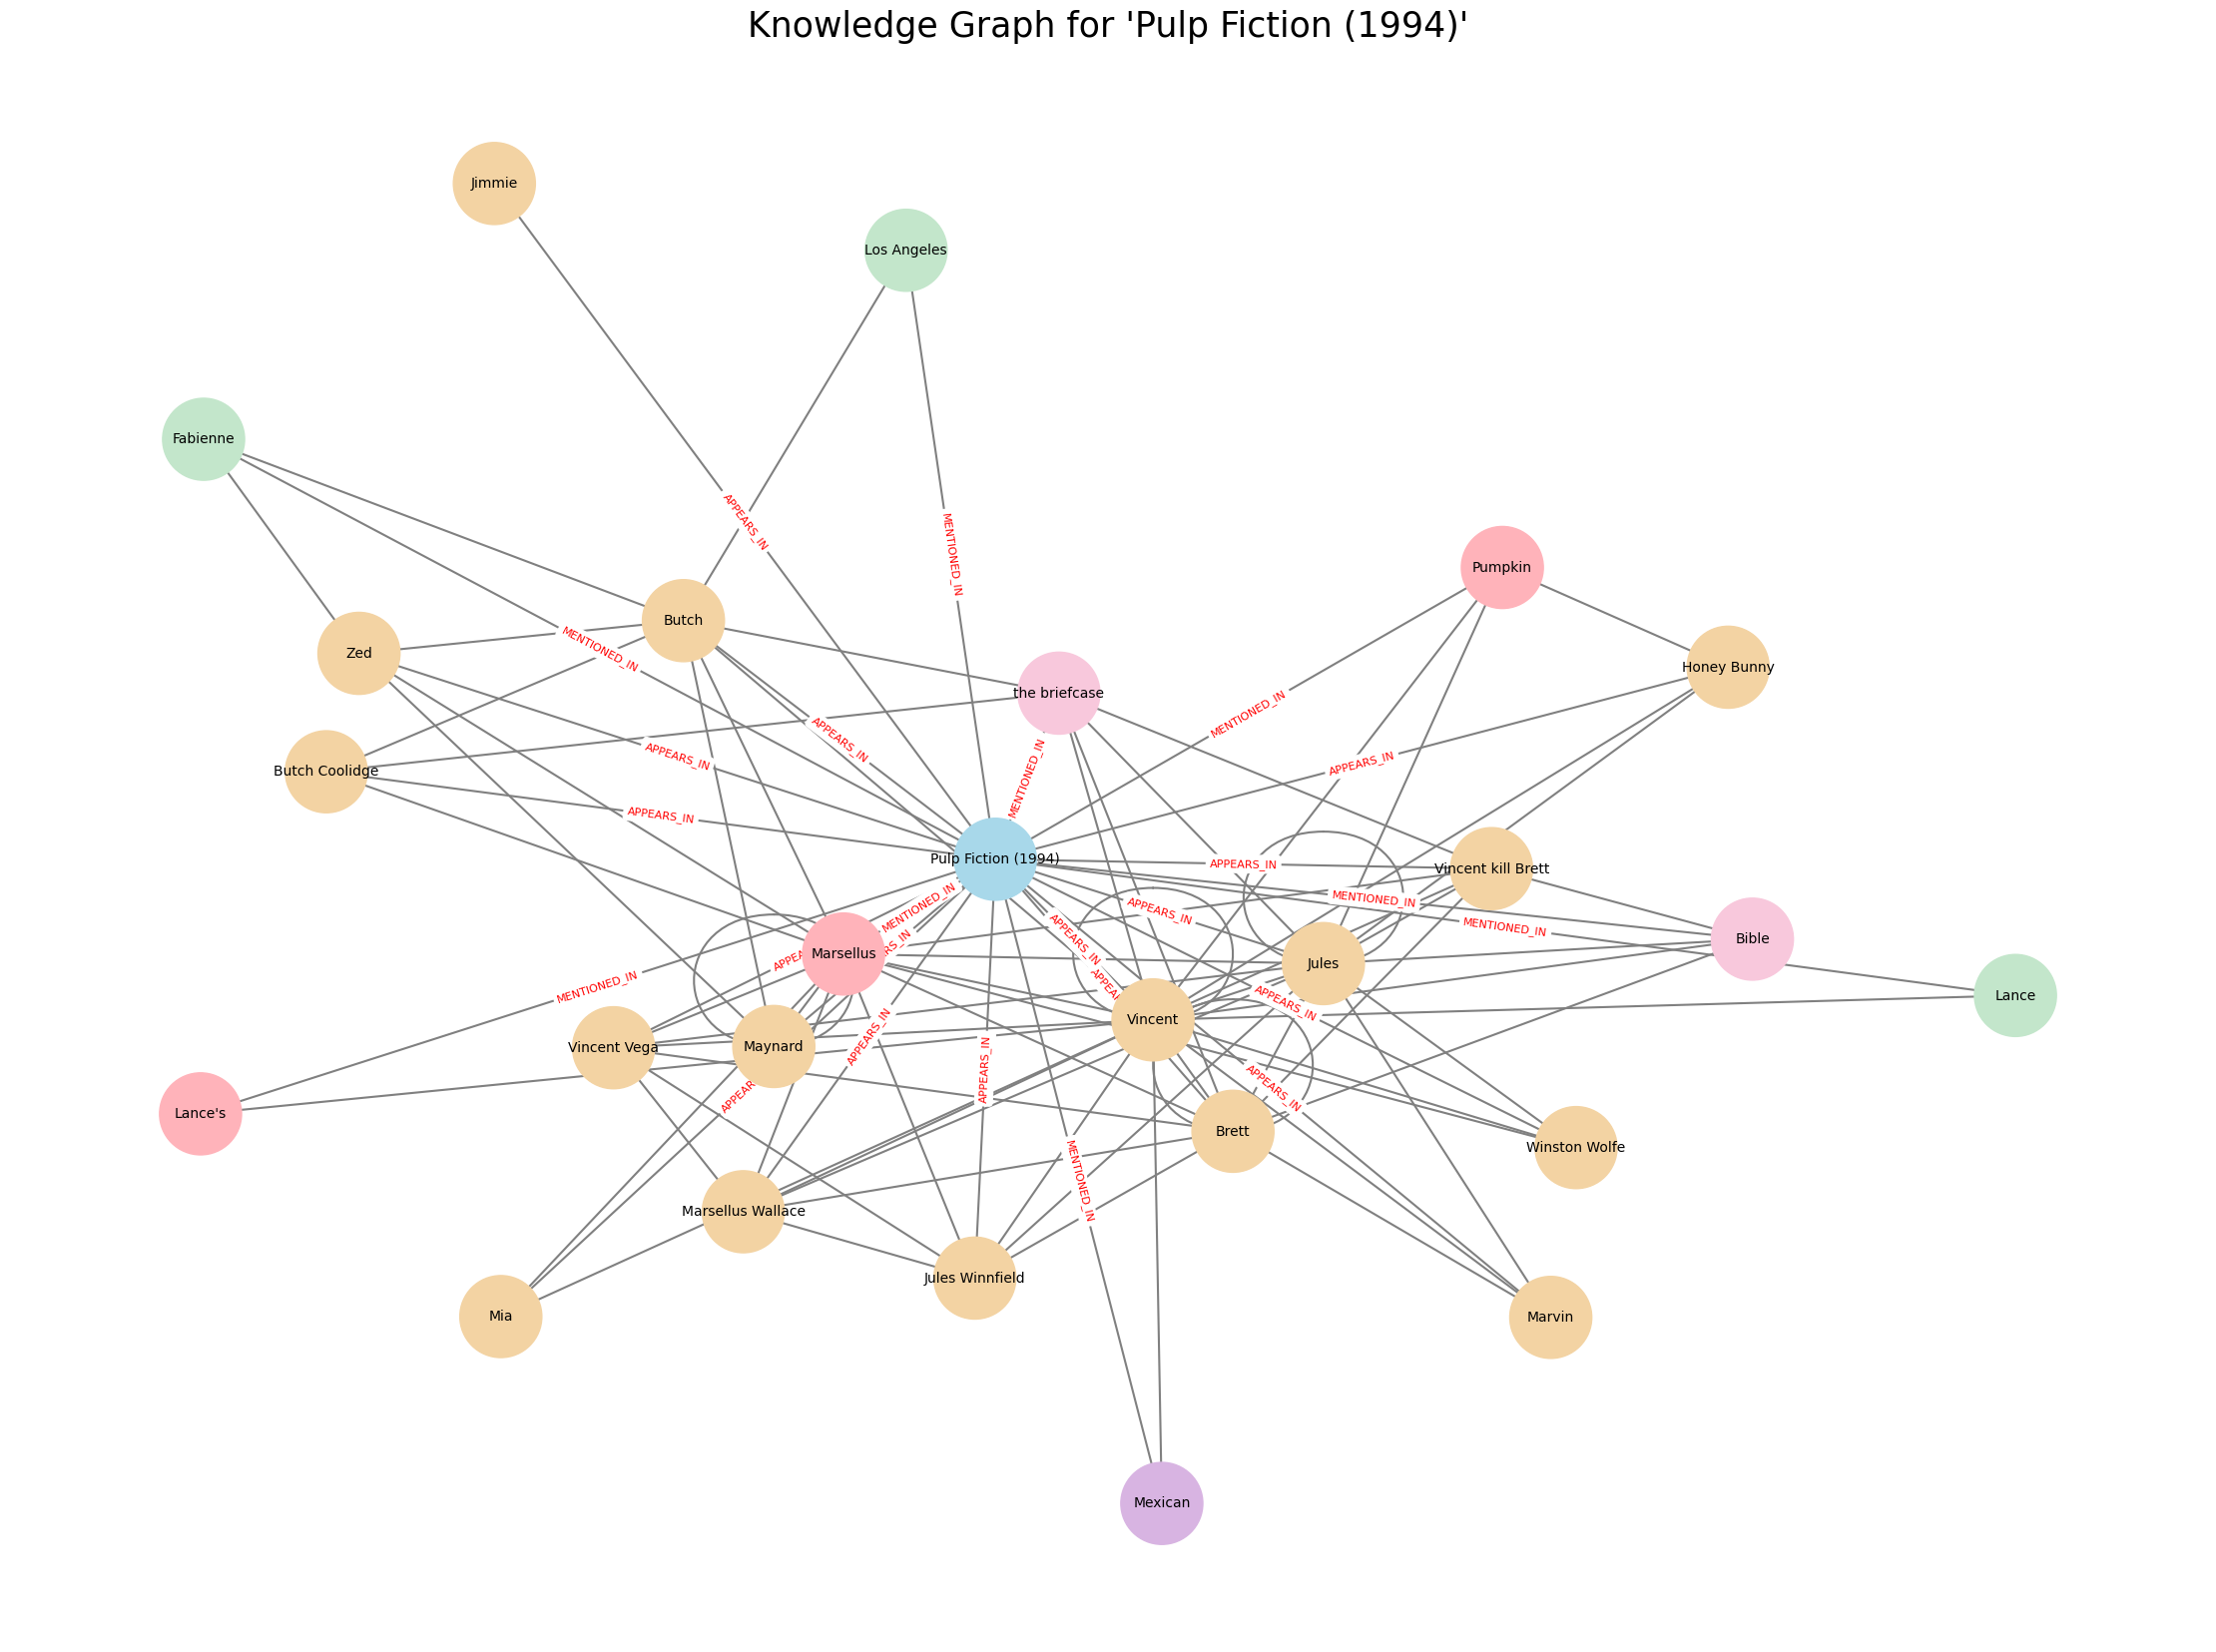

In [ ]:
# Prepare for drawing the graph
pos = nx.spring_layout(MovieKG, seed=42, k=0.9, iterations=50)

# Define colors for our node types
color_map = {
    'Movie': '#a8d8ea', 'Character': '#f3d3a3', 'Location': '#c3e6cb',
    'Organization': '#ffb3ba', 'Faction': '#d8b4e2', 'Item': '#f8c8dc',
    'PlotPoint': '#ffaaa5', 'Concept': '#d3d3d3'
}
node_colors = [color_map.get(MovieKG.nodes[node]['type'], '#cccccc') for node in MovieKG.nodes()]

# Create the plot
plt.figure(figsize=(22, 16))
nx.draw(
    MovieKG, pos, with_labels=True, node_size=3500, node_color=node_colors,
    font_size=10, edge_color='gray', width=1.5
)

# Draw edge labels for key relationships to reduce clutter
edge_labels = nx.get_edge_attributes(MovieKG, 'type')
filtered_labels = {k: v for k, v in edge_labels.items() if v not in ['INTERACTS_WITH', 'USES_OR_VISITS']}
nx.draw_networkx_edge_labels(MovieKG, pos, edge_labels=filtered_labels, font_color='red', font_size=8)

plt.title(f"Knowledge Graph for '{MOVIE_TITLE}'", size=25)
plt.show()

-----

### Part 7: Comparison - Can an LLM Do Better?

Our programmatic approach created a graph based on a simple co-occurrence heuristic. An advanced LLM, with its vast world knowledge, can infer much more specific and accurate relationships in a zero-shot manner. Below is a graph generated from the same plot, showcasing the detailed relationships an LLM can extract.

This highlights the trade-off: our method is systematic and scalable, while the LLM's is more nuanced but requires significant computational power and careful prompt engineering.

-----

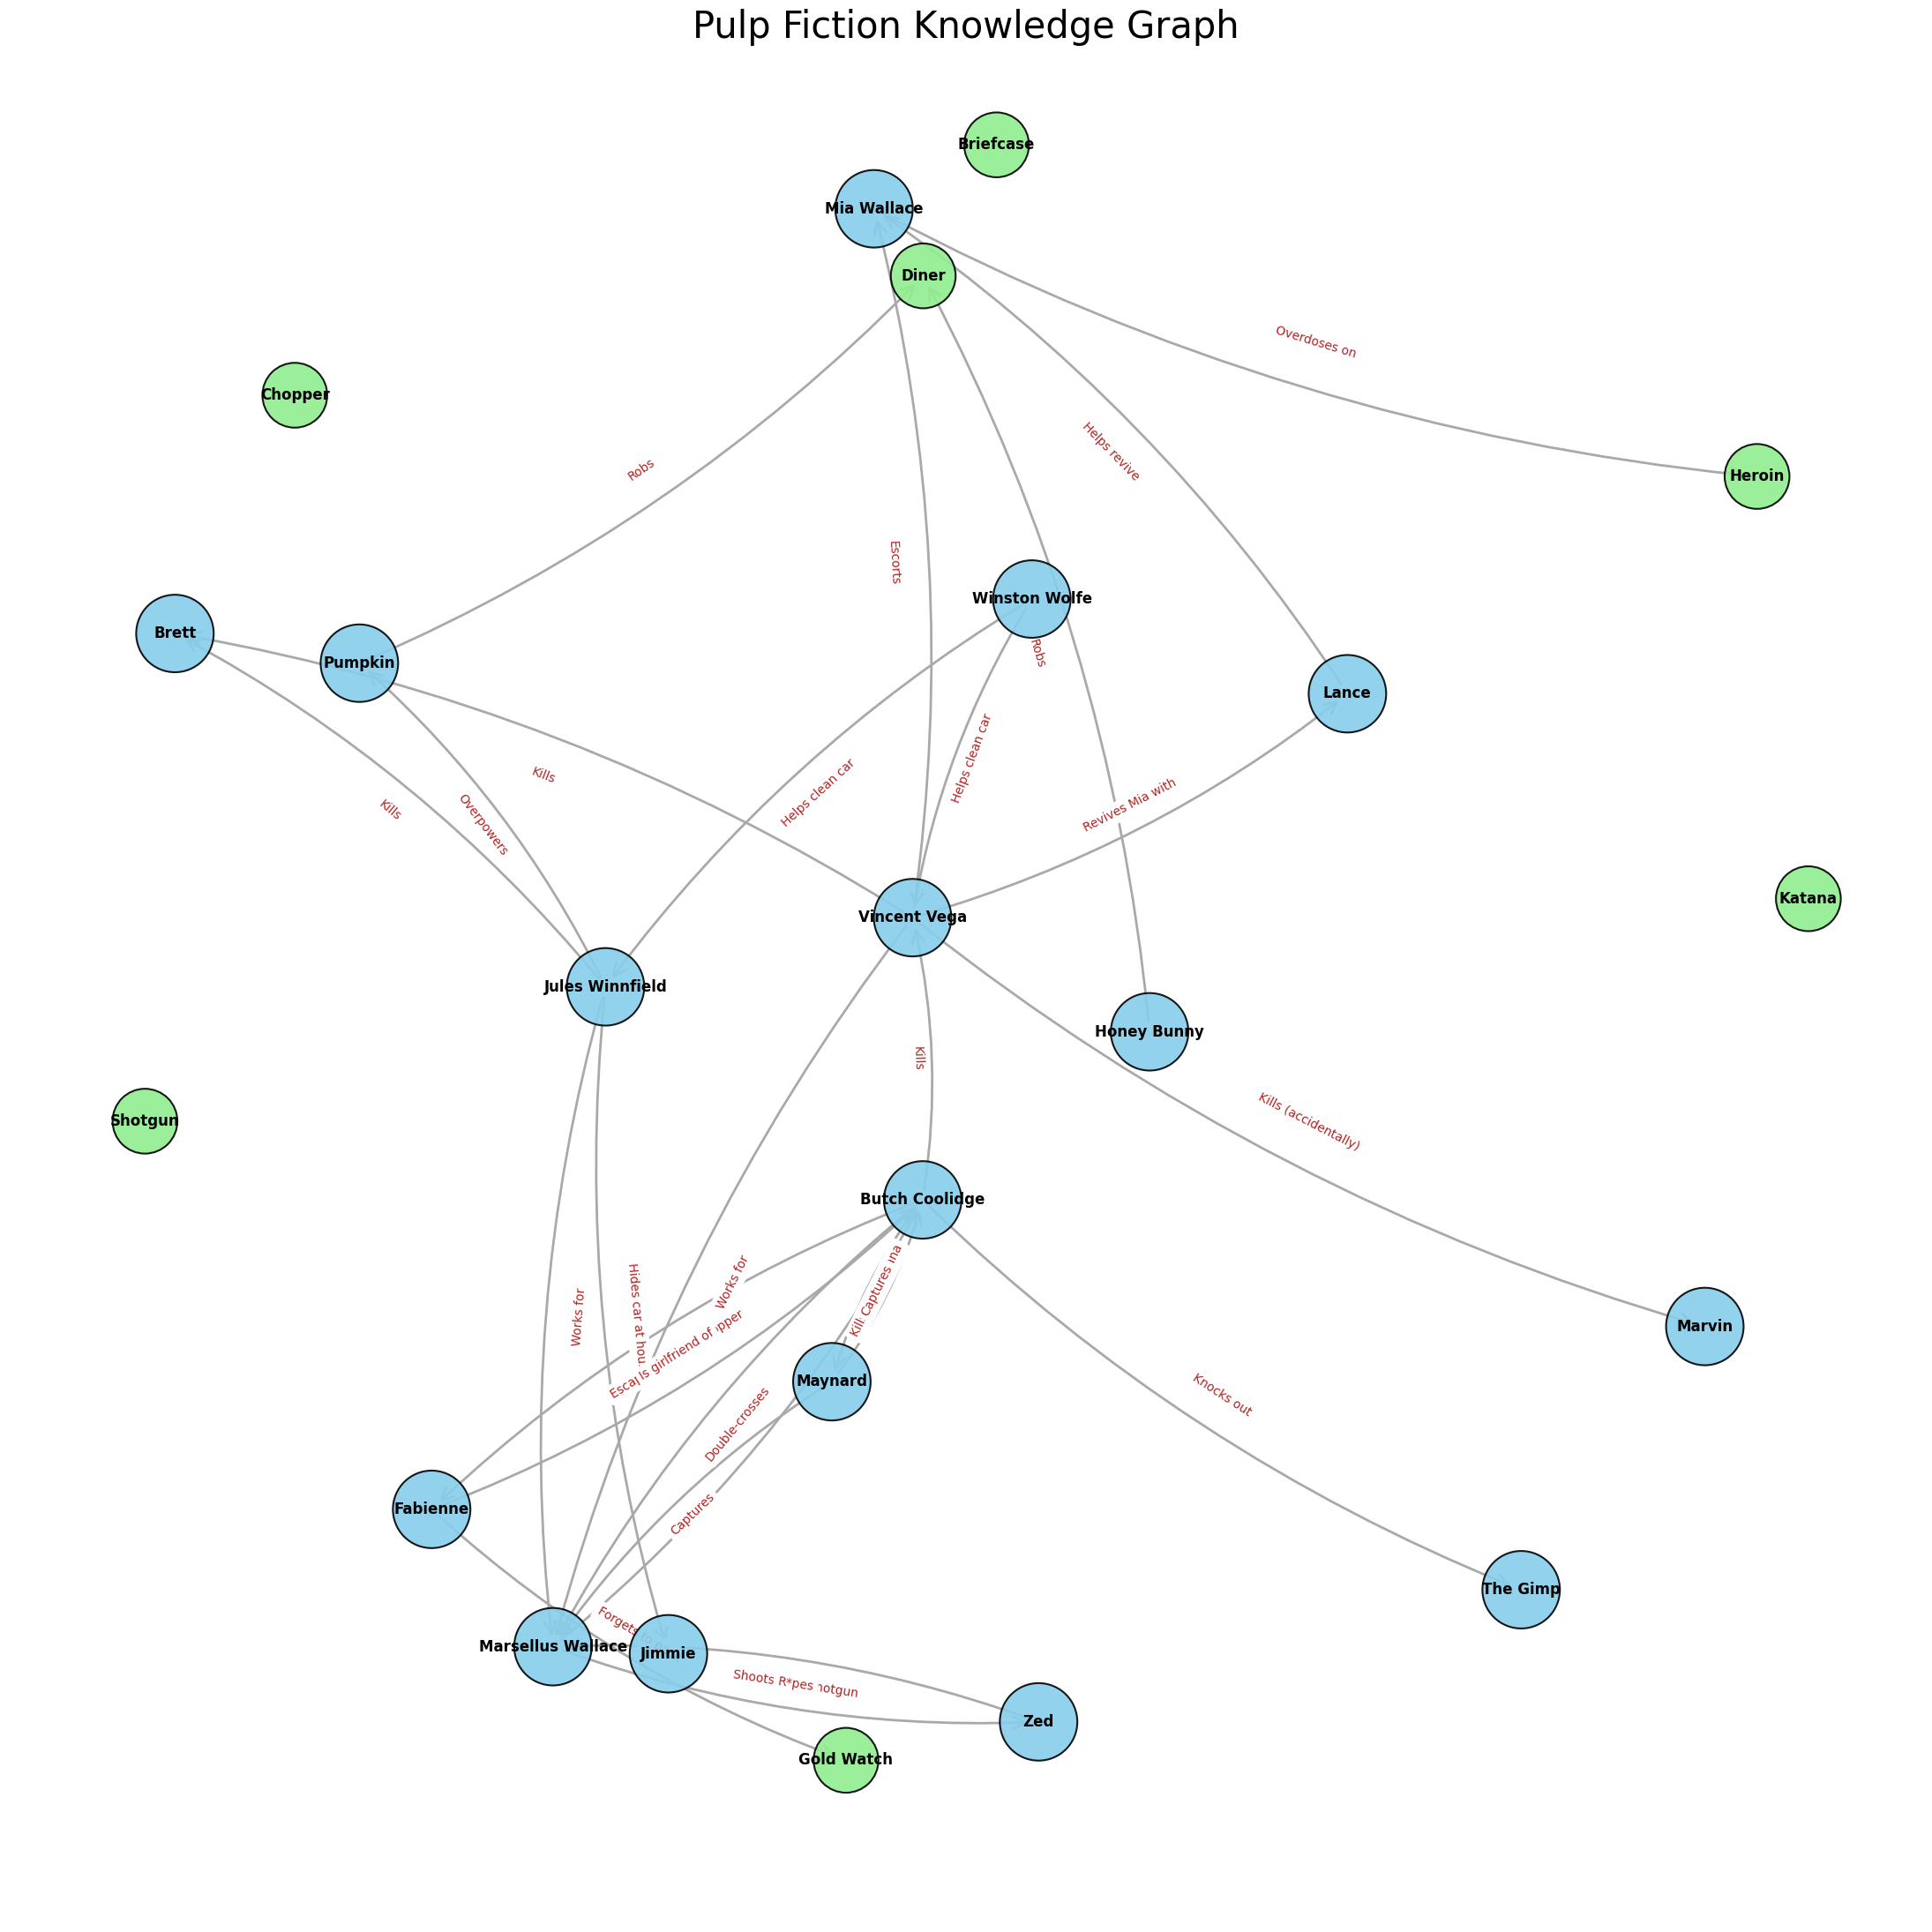

Knowledge graph image 'pulp_fiction_kg.png' has been saved to your directory.


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# --- Define Nodes (Entities) ---
characters = [
    "Jules Winnfield", "Vincent Vega", "Marsellus Wallace", "Brett",
    "Butch Coolidge", "Mia Wallace", "Lance", "Fabienne",
    "Maynard", "Zed", "The Gimp", "Jimmie", "Winston Wolfe",
    "Pumpkin", "Honey Bunny", "Marvin"
]
items_and_locations = ["Briefcase", "Heroin", "Gold Watch", "Katana", "Shotgun", "Chopper", "Diner"]

# Add nodes to the graph with a 'type' attribute
for char in characters:
    G.add_node(char, type='person')
for item in items_and_locations:
    G.add_node(item, type='item')

# --- Define Edges (Relationships) ---
edges_with_labels = [
    # Jules and Vincent's storyline
    ("Jules Winnfield", "Marsellus Wallace", "Works for"),
    ("Vincent Vega", "Marsellus Wallace", "Works for"),
    ("Jules Winnfield", "Brett", "Retrieves briefcase from"),
    ("Vincent Vega", "Brett", "Retrieves briefcase from"),
    ("Jules Winnfield", "Brett", "Kills"),
    ("Vincent Vega", "Brett", "Kills"),
    ("Vincent Vega", "Marvin", "Kills (accidentally)"),
    ("Jules Winnfield", "Jimmie", "Hides car at house"),
    ("Winston Wolfe", "Jules Winnfield", "Helps clean car"),
    ("Winston Wolfe", "Vincent Vega", "Helps clean car"),

    # Vincent and Mia's storyline
    ("Vincent Vega", "Lance", "Buys heroin from"),
    ("Vincent Vega", "Mia Wallace", "Escorts"),
    ("Mia Wallace", "Heroin", "Overdoses on"),
    ("Vincent Vega", "Lance", "Revives Mia with"),
    ("Lance", "Mia Wallace", "Helps revive"),

    # Butch's storyline
    ("Marsellus Wallace", "Butch Coolidge", "Bribes"),
    ("Butch Coolidge", "Marsellus Wallace", "Double-crosses"),
    ("Butch Coolidge", "Vincent Vega", "Kills"),
    ("Fabienne", "Butch Coolidge", "Is girlfriend of"),
    ("Fabienne", "Gold Watch", "Forgets to pack"),
    ("Marsellus Wallace", "Butch Coolidge", "Chases"),
    ("Maynard", "Butch Coolidge", "Captures"),
    ("Maynard", "Marsellus Wallace", "Captures"),
    ("Zed", "Marsellus Wallace", "R*pes"),
    ("Butch Coolidge", "The Gimp", "Knocks out"),
    ("Butch Coolidge", "Maynard", "Kills with Katana"),
    ("Marsellus Wallace", "Zed", "Shoots with Shotgun"),
    ("Marsellus Wallace", "Butch Coolidge", "Forgives"),
    ("Butch Coolidge", "Fabienne", "Escapes with on Chopper"),

    # Diner storyline
    ("Pumpkin", "Diner", "Robs"),
    ("Honey Bunny", "Diner", "Robs"),
    ("Jules Winnfield", "Pumpkin", "Overpowers"),
]

# Add the edges to the graph
for u, v, label in edges_with_labels:
    G.add_edge(u, v, label=label)

# --- Visualization ---
plt.figure(figsize=(22, 22))

# Use a spring layout to position nodes automatically
pos = nx.spring_layout(G, k=1.3, iterations=70, seed=42)

# Define node colors and sizes based on their type
node_colors = ["skyblue" if G.nodes[node]['type'] == 'person' else "lightgreen" for node in G.nodes]
node_sizes = [4000 if G.nodes[node]['type'] == 'person' else 2800 for node in G.nodes]

# Draw the graph components
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9, linewidths=1.5, edgecolors='black')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=25, edge_color='darkgray', width=2.0, connectionstyle='arc3,rad=0.1')
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif', font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='firebrick', font_size=10)

# Display the final plot
plt.title("Pulp Fiction Knowledge Graph", size=30)
plt.axis('off')
plt.tight_layout()
plt.savefig("pulp_fiction_kg.png", format="PNG", dpi=300)
plt.show()

